# Data upload

In [1]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import gzip
import Preprocessing as pproc 
import HerdingFunctions as hf
import statsmodels.api as sm

directory = os.getcwd()
data_path = os.path.join(directory, 'Data')

# Definining the path for the files
RB_path = os.path.join(data_path, 'RateBeer')
BA_path = os.path.join(data_path, 'BeerAdvocate')
MB_path = os.path.join(data_path, 'matched_beer_data')

# Extraction of the data and preprocessing of the files

In [2]:
# Extraction of the .tar files
pproc.extract_tar_files(data_path)

In [3]:
#Transformation of the .txt files
pproc.text_to_csv(RB_path, 'ratings')
pproc.text_to_csv(RB_path, 'reviews')

pproc.text_to_csv(BA_path, 'ratings')
pproc.text_to_csv(BA_path, 'reviews')

pproc.text_to_csv(MB_path, 'ratings_ba')
pproc.text_to_csv(MB_path, 'ratings_with_text_ba')
pproc.text_to_csv(MB_path, 'ratings_rb')
pproc.text_to_csv(MB_path, 'ratings_with_text_rb')

# Creation of dataframes

Matching data:

In [4]:
MB_beers = pd.read_csv(MB_path + '/beers.csv', header=1)
MB_breweries = pd.read_csv(MB_path + '/breweries.csv', header=1)
MB_users = pd.read_csv(MB_path + '/users.csv', header=1)
MB_users_approx = pd.read_csv(MB_path + '/users_approx.csv', header=1)

In [5]:
MB_ratings = pd.read_csv(MB_path + '/ratings.csv', header=1)
MB_ratingsBA = pd.read_csv(MB_path + '/ratings_ba.tsv', sep='\t')
MB_ratingsBA_txt = pd.read_csv(MB_path + '/ratings_with_text_ba.tsv', sep='\t')
MB_ratingsRB = pd.read_csv(MB_path + '/ratings_rb.tsv', sep='\t')
MB_ratingsRB_txt = pd.read_csv(MB_path + '/ratings_with_text_rb.tsv', sep='\t')

Rest of the data:

In [6]:
RB_beers = pd.read_csv(RB_path + '/beers.csv')
RB_breweries = pd.read_csv(RB_path + '/breweries.csv')
RB_users = pd.read_csv(RB_path + '/users.csv')
RB_ratings = pd.read_csv(RB_path + '/ratings.tsv', sep='\t')
RB_reviews = pd.read_csv(RB_path + '/reviews.tsv', sep='\t')

In [7]:
BA_beers = pd.read_csv(BA_path + '/beers.csv')
BA_breweries = pd.read_csv(BA_path + '/breweries.csv')
BA_users = pd.read_csv(BA_path + '/users.csv')
BA_ratings = pd.read_csv(BA_path + '/ratings.tsv', sep='\t')
BA_reviews = pd.read_csv(BA_path + '/reviews.tsv', sep='\t')

In [9]:
BA_ratings

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,1440064800,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with...",True
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1235127600,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quick...,True
2,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1142247600,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim....",True
3,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1101898800,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,Serving: 500ml brown bottlePour: Good head wi...,True
4,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1093860000,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,"500ml bottlePours with a light, slightly hazy...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8393027,Kölsch Ale,19139,Summit Station Restaurant & Brewery,885,Kölsch,5.0,1141038000,jaluria,jaluria.31362,3.50,3.50,3.50,4.00,4.0,3.80,I'll start off reviewing this beer with the f...,True
8393028,Kölsch Ale,19139,Summit Station Restaurant & Brewery,885,Kölsch,5.0,1140346800,Dithyramb,dithyramb.4413,3.00,3.00,3.00,2.50,3.0,2.80,Served on draft at the pub. Poured a clear ye...,True
8393029,Kölsch Ale,19139,Summit Station Restaurant & Brewery,885,Kölsch,5.0,1092132000,ManekiNeko,manekineko.2654,3.00,1.50,1.00,1.50,1.5,1.54,Served on tap at the brewpub in a pint glass....,True
8393030,Nut Brown Ale,19140,Summit Station Restaurant & Brewery,885,English Brown Ale,5.3,1341741600,Redsox1539,redsox1539.683632,NaN,NaN,NaN,NaN,NaN,3.50,NaN,False


In [10]:
total_ratings = pd.concat([BA_ratings, RB_ratings])

In [11]:
all_styles = pd.unique(total_ratings['style'])
all_styles = pd.DataFrame(all_styles)

all_styles = all_styles.sort_values(0)


In [12]:
all_styles.to_csv('all_beer_styles.csv')

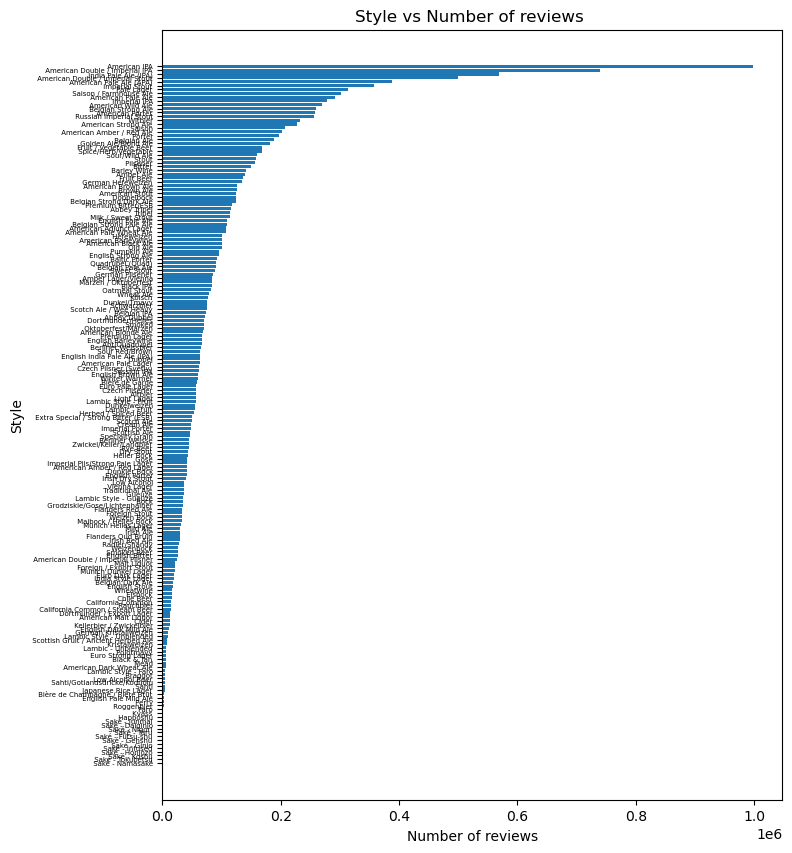

In [13]:
#Here we will see how is the distribution of the different beers

value_counts = total_ratings['style'].value_counts()

fig, ax = plt.subplots( figsize = (8,10))
ax.barh(value_counts.index, value_counts)

# Set labels and title
ax.set_xlabel('Number of reviews')
ax.set_ylabel('Style')
ax.set_title('Style vs Number of reviews ')
ax.tick_params(axis = 'x', labelsize = 10)
ax.tick_params(axis = 'y', labelsize = 5)

# Rotate the entire plot by 90 degrees
plt.gca().invert_yaxis()  # Invert y-axis to make the plot more readable
plt.show()

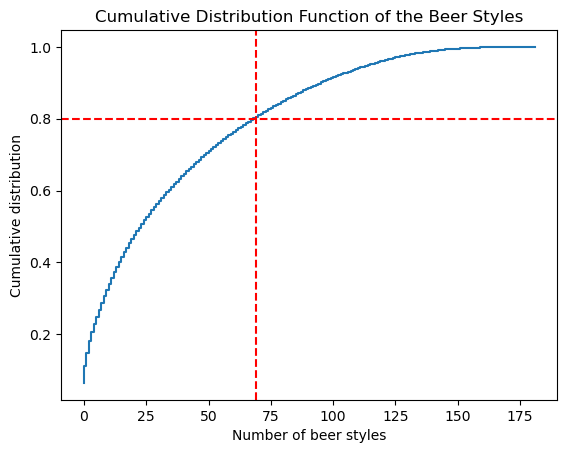

In [14]:
value_counts = total_ratings['style'].value_counts()
df_value_counts = pd.DataFrame(value_counts.values, columns = ['counts'], index = value_counts.index.values)
interval = np.arange(1, len(df_value_counts['counts'].values)+1)

cumulative_df = pd.DataFrame( df_value_counts['counts'].cumsum().values, columns= ['counts'])

cumulative_df = cumulative_df/value_counts.sum()

x_value_at_y_05 = cumulative_df.loc[cumulative_df['counts'] >= 0.8].index[0]


plt.step(cumulative_df.index.values, cumulative_df['counts'])
plt.xlabel('Number of beer styles')
plt.ylabel('Cumulative distribution')
plt.title('Cumulative Distribution Function of the Beer Styles')


plt.axhline(y = 0.8, color = 'red', linestyle = '--')
plt.axvline(x = x_value_at_y_05, color = 'red', linestyle = '--')

#25 beers style represent 50% of the whole type of beers
#70 beers style represents 80% of the whole type of beers



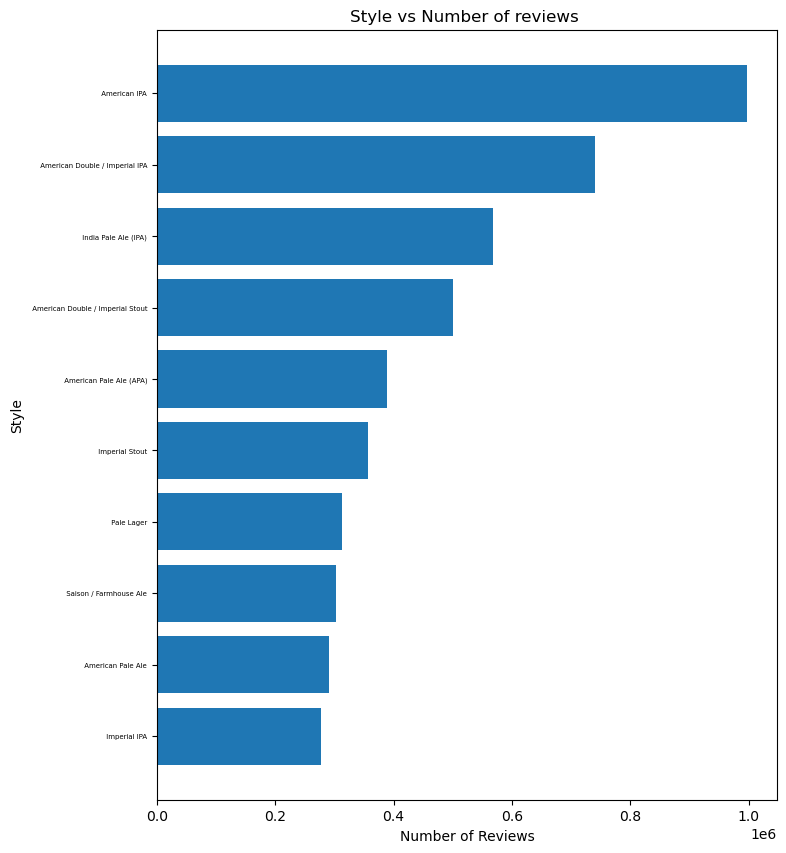

The top 10 more reviewed beer styles, represent the: 30.5224082903462% among the total 182 beer styles


In [15]:
#The top ten beer styles, how much it represents:
top_10_percentage = cumulative_df['counts'][9]

fig, ax = plt.subplots( figsize = (8,10))
ax.barh(value_counts.index[0:10], value_counts[0:10])

# Set labels and title
ax.set_xlabel('Number of Reviews')
ax.set_ylabel('Style')
ax.set_title('Style vs Number of reviews ')
ax.tick_params(axis = 'x', labelsize = 10)
ax.tick_params(axis = 'y', labelsize = 5)

# Rotate the entire plot by 90 degrees
plt.gca().invert_yaxis()  # Invert y-axis to make the plot more readable
plt.show()
print(f"The top 10 more reviewed beer styles, represent the: {top_10_percentage * 100}% among the total 182 beer styles")

We can clearly see that the data is skewed and multiple beer style are not considered with respect to the size of the number of reviews. Therefore, for consideing multiple beer styles, and being able to reduce the dimension and get insightfull information, we grouped the styles by "superior styles". Additionally, this is done for decreasing the bias that in a specific country, people would tend to consume the regional beer. For example, american IPA and Belgian IPA, are both IPA, even thought they have different characteristics, we could group them as IPA.

In [16]:
total_ratings['style'] = total_ratings['style'].str.strip()

In [17]:
beer_dict = {
    'American Pale Ale': 'Pale Ale',
    'American Blonde Ale': 'Pale Ale',
    'Golden Ale/Blond Ale': 'Pale Ale',
    'Bitter': 'Pale Ale',
    'Pale Ale': 'Pale Ale',
    'American Pale Ale (APA)': 'Pale Ale',
    'English Pale Ale': 'Pale Ale',
    'English Bitter': 'Pale Ale',
    'Premium Bitter/ESB': 'Pale Ale',
    'English India Pale Ale (IPA)': 'Pale Ale',
    'Extra Special / Strong Bitter (ESB)': 'Pale Ale',
    'Saison / Farmhouse Ale': 'Pale Ale',
    'English Pale Mild Ale': 'Pale Ale',
    'Saison': 'Pale Ale',
    'Belgian Pale Ale': 'Pale Ale',
    'Belgian Strong Pale Ale': 'Strong Pale Ale',
    'Tripel': 'Strong Pale Ale',
    'Abbey Tripel': 'Strong Pale Ale',
    'American IPA': 'IPA',
    'Black IPA': 'IPA',
    'India Pale Ale (IPA)': 'IPA',
    'American Double / Imperial IPA': 'IPA',
    'Imperial IPA': 'IPA',
    'New England IPA (NEIPA)': 'IPA',
    'Session IPA': 'IPA',
    'Belgian IPA': 'IPA',
    'Abbey Dubbel': 'Brown/Dark Ale',
    'Dubbel': 'Brown/Dark Ale',
    'Belgian Dark Ale': 'Brown/Dark Ale',
    'American Brown Ale': 'Brown/Dark Ale',
    'Brown Ale': 'Brown/Dark Ale',
    'English Dark Mild Ale': 'Brown/Dark Ale',
    'American Black Ale': 'Brown/Dark Ale',
    'English Brown Ale': 'Brown/Dark Ale',
    'Belgian Strong Dark Ale': 'Strong Brown/Dark Ale',
    'Abt/Quadrupel': 'Strong Brown/Dark Ale',
    'Barley Wine': 'Strong Brown/Dark Ale',
    'English Barleywine': 'Strong Brown/Dark Ale',
    'American Barleywine': 'Strong Brown/Dark Ale',
    'Quadrupel (Quad)': 'Strong Brown/Dark Ale',
    'Amber Ale': 'Amber Ale',
    'American Amber Ale': 'Amber Ale',
    'Irish Red Ale': 'Amber Ale',
    'American Amber / Red Ale': 'Amber Ale',
    'Red Ale': 'Amber Ale',
    'Belgian Ale': 'Ale',
    'Irish Ale': 'Ale',
    'Old Ale': 'Ale',
    'Mild Ale': 'Ale',
    'Traditional Ale': 'Ale',
    'Scotch Ale / Wee Heavy': 'Ale',
    'Scotch Ale': 'Ale',
    'Scottish Ale': 'Ale',
    'Belgian Strong Ale': 'Strong Ale',
    'American Strong Ale': 'Strong Ale',
    'English Strong Ale': 'Strong Ale',
    'Winter Warmer': 'Strong Ale',
    'Stout': 'Stout',
    'American Stout': 'Stout',
    'Dry Stout': 'Stout',
    'American Double / Imperial Stout': 'Stout',
    'English Stout': 'Stout',
    'Imperial Stout': 'Stout',
    'Irish Dry Stout': 'Stout',
    'Foreign / Export Stout': 'Stout',
    'Oatmeal Stout': 'Stout',
    'Russian Imperial Stout': 'Stout',
    'Milk / Sweet Stout': 'Stout',
    'Foreign Stout': 'Stout',
    'Sweet Stout': 'Stout',
    'Porter': 'Porter',
    'American Porter': 'Porter',
    'Baltic Porter': 'Porter',
    'Imperial Porter': 'Porter',
    'English Porter': 'Porter',
    'American Dark Wheat Ale': 'Wheat Beer',
    'Berliner Weissbier': 'Wheat Beer',
    'Dunkelweizen': 'Wheat Beer',
    'German Hefeweizen': 'Wheat Beer',
    'Hefeweizen': 'Wheat Beer',
    'Wheat Ale': 'Wheat Beer',
    'Weizen Bock': 'Wheat Beer',
    'Roggenbier': 'Wheat Beer',
    'Weizenbock': 'Wheat Beer',
    'Witbier': 'Wheat Beer',
    'German Kristallweizen': 'Wheat Beer',
    'Berliner Weisse': 'Wheat Beer',
    'Kristalweizen': 'Wheat Beer',
    'Wheatwine': 'Wheat Beer',
    'Dunkelweizen': 'Wheat Beer',
    'American Pale Wheat Ale': 'Wheat Beer',
    'Flanders Oud Bruin': 'Wild/Sour Beer',
    'Flanders Red Ale': 'Wild/Sour Beer',
    'Gose': 'Wild/Sour Beer',
    'Lambic - Fruit': 'Wild/Sour Beer',
    'American Wild Ale': 'Wild/Sour Beer',
    'Lambic - Unblended': 'Wild/Sour Beer',
    'Lambic Style - Faro': 'Wild/Sour Beer',
    'Lambic Style - Fruit': 'Wild/Sour Beer',
    'Lambic Style - Gueuze': 'Wild/Sour Beer',
    'Lambic Style - Unblended': 'Wild/Sour Beer',
    'Sour Red/Brown': 'Wild/Sour Beer',
    'Sour/Wild Ale': 'Wild/Sour Beer',
    'Faro': 'Wild/Sour Beer',
    'Gueuze': 'Wild/Sour Beer',
    'Grodziskie/Gose/Lichtenhainer': 'Wild/Sour Beer',
    'American Adjunct Lager': 'Pilsner & Pale Lager',
    'American Pale Lager': 'Pilsner & Pale Lager',
    'Pilsener': 'Pilsner & Pale Lager',
    'Dortmunder / Export Lager': 'Pilsner & Pale Lager',
    'European Pale Lager': 'Pilsner & Pale Lager',
    'German Pilsener': 'Pilsner & Pale Lager',
    'Pale Lager': 'Pilsner & Pale Lager',
    'Munich Helles Lager': 'Pilsner & Pale Lager',
    'Pilsener (German and Czech)': 'Pilsner & Pale Lager',
    'Czech Pilsener': 'Pilsner & Pale Lager',
    'Czech Pilsner (Světlý)': 'Pilsner & Pale Lager',
    'India Style Lager': 'Pilsner & Pale Lager',
    'Imperial Pils/Strong Pale Lager': 'Pilsner & Pale Lager',
    'Kellerbier / Zwickelbier': 'Pilsner & Pale Lager',
    'Euro Pale Lager': 'Pilsner & Pale Lager',
    'Zwickel/Keller/Landbier': 'Pilsner & Pale Lager',
    'Euro Strong Lager': 'Pilsner & Pale Lager',
    'American Double / Imperial Pilsner': 'Pilsner & Pale Lager',
    'Light Lager': 'Pilsner & Pale Lager',
    'Radler/Shandy': 'Pilsner & Pale Lager',
    'Japanese Rice Lager': 'Pilsner & Pale Lager',
    'Premium Lager': 'Pilsner & Pale Lager',
    'Dortmunder/Helles': 'Pilsner & Pale Lager',
    'Doppelbock': 'Bock',
    'Eisbock': 'Bock',
    'Heller Bock': 'Bock',
    'Maibock / Helles Bock': 'Bock',
    'Bock': 'Bock',
    'Amber Lager/Vienna': 'Dark Lager',
    'Munich Dunkel Lager': 'Dark Lager',
    'Schwarzbier': 'Dark Lager',
    'Vienna Lager': 'Dark Lager',
    'American Amber / Red Lager': 'Dark Lager',
    'Dunkel/Tmavý': 'Dark Lager',
    'Dunkler Bock': 'Dark Lager',
    'Euro Dark Lager': 'Dark Lager',
    'Schwarzbier': 'Dark Lager',
    'Polotmavý': 'Dark Lager',
    'Märzen / Oktoberfest': 'Dark Lager',
    'Oktoberfest/Märzen': 'Dark Lager',
    'Rauchbier': 'Smoked',
    'Smoked': 'Smoked',
    'Smoked Beer': 'Smoked',
    'Cream Ale': 'Hybrid Beer',
    'Kölsch': 'Hybrid Beer',
    'California Common': 'Hybrid Beer',
    'California Common / Steam Beer': 'Hybrid Beer',
    'Braggot': 'Hybrid Beer',
    'Bière de Garde': 'Hybrid Beer',
    'Black & Tan': 'Hybrid Beer',
    'Altbier': 'Hybrid Beer',
    'Rye Beer': 'Hybrid Beer',
    'Chile Beer': 'Herbs/Vegetables',
    'Cider': 'Herbs/Vegetables',
    'Fruit / Vegetable Beer': 'Herbs/Vegetables',
    'Fruit Beer': 'Herbs/Vegetables',
    'Herbed / Spiced Beer': 'Herbs/Vegetables',
    'Mead': 'Herbs/Vegetables',
    'Spice/Herb/Vegetable': 'Herbs/Vegetables',
    'Specialty Grain': 'Herbs/Vegetables',
    'Sahti': 'Herbs/Vegetables',
    'Sahti/Gotlandsdricke/Koduõlu': 'Herbs/Vegetables',
    'Scottish Gruit / Ancient Herbed Ale': 'Herbs/Vegetables',
    'Pumpkin Ale': 'Herbs/Vegetables',
    'Perry': 'Herbs/Vegetables',
    'Happoshu': 'Low Alcohol',
    'Low Alcohol': 'Low Alcohol',
    'Low Alcohol Beer': 'Low Alcohol',
    'Kvass': 'Low Alcohol',
    'American Malt Liquor': 'Cocktails',
    'Bière de Champagne / Bière Brut': 'Cocktails',
    'Malt Liquor': 'Cocktails',
    'Saké - Daiginjo': 'Cocktails',
    'Saké - Futsu-shu': 'Cocktails',
    'Saké - Genshu': 'Cocktails',
    'Saké - Ginjo': 'Cocktails',
    'Saké - Honjozo': 'Cocktails',
    'Saké - Infused': 'Cocktails',
    'Saké - Junmai': 'Cocktails',
    'Saké - Koshu': 'Cocktails',
    'Saké - Namasaké': 'Cocktails',
    'Saké - Nigori': 'Cocktails',
    'Saké - Taru': 'Cocktails',
    'Saké - Tokubetsu': 'Cocktails'
}

In [18]:
total_ratings['categories'] = total_ratings['style'].map(beer_dict)

In [19]:
total_ratings

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,categories
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,1440064800,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with...",True,Pilsner & Pale Lager
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1235127600,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quick...,True,Pale Ale
2,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1142247600,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim....",True,Pale Ale
3,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1101898800,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,Serving: 500ml brown bottlePour: Good head wi...,True,Pale Ale
4,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1093860000,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,"500ml bottlePours with a light, slightly hazy...",True,Pale Ale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7122069,Svejk Blonde,220897,Svejk Beer Garden,17155,Pale Lager,NaN,1411034400,Travlr,83882,3.00,6.00,2.00,5.00,10.0,2.60,"Draft at the source. Clear golden color, fluf...",NaN,Pilsner & Pale Lager
7122070,Svejk Blonde,220897,Svejk Beer Garden,17155,Pale Lager,NaN,1385895600,TBone,10233,2.00,5.00,2.00,6.00,10.0,2.50,"Tap @brewpub, TiraneClear golden color, good ...",NaN,Pilsner & Pale Lager
7122071,Svejk Dark,220898,Svejk Beer Garden,17155,Dunkel/Tmavý,NaN,1415098800,Rob_D_UK,257161,3.00,4.00,2.00,5.00,9.0,2.30,In their beer garden after a walking tour aro...,NaN,Dark Lager
7122072,Svejk Dark,220898,Svejk Beer Garden,17155,Dunkel/Tmavý,NaN,1410861600,Travlr,83882,3.00,5.00,1.00,4.00,6.0,1.90,"Draft at the source. Hazy maroon color, tan h...",NaN,Dark Lager


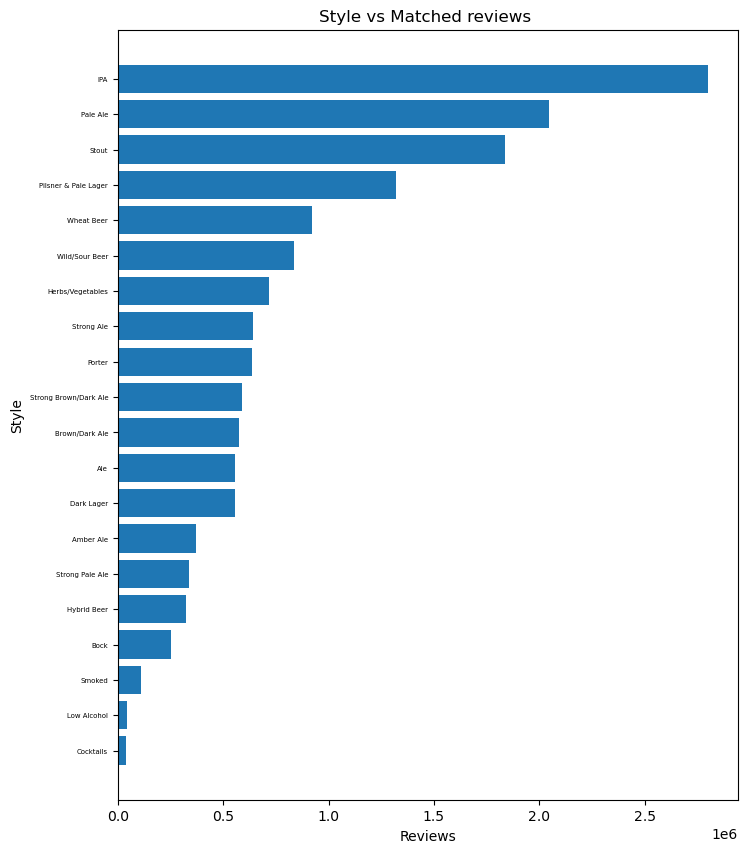

In [20]:
grouping_values = total_ratings['categories'].value_counts()

fig, ax = plt.subplots( figsize = (8,10))
ax.barh(grouping_values.index, grouping_values)

# Set labels and title
ax.set_xlabel('Reviews')
ax.set_ylabel('Style')
ax.set_title('Style vs Matched reviews ')
ax.tick_params(axis = 'x', labelsize = 10)
ax.tick_params(axis = 'y', labelsize = 5)

# Rotate the entire plot by 90 degrees
plt.gca().invert_yaxis()  # Invert y-axis to make the plot more readable
plt.show()

<Axes: ylabel='count'>

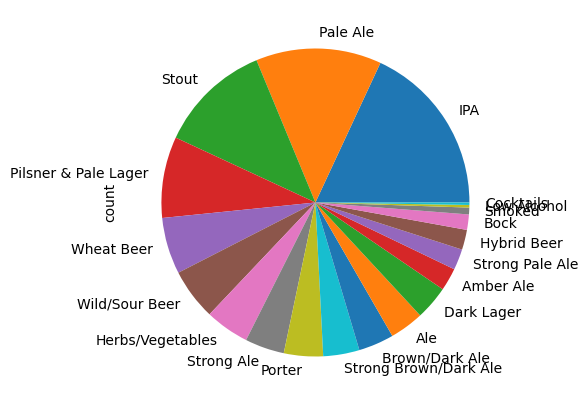

: 

In [21]:
#Now I need to calculate the average score for the users based on the categories
grouping_values.plot.pie( figsize = (5,5))

Now we can represent around 50% of the data with 4 major groups of beers

In [21]:
#Lets suppose that the ratings are calculated with the same formula

style_pref_merged = pd.crosstab(total_ratings['user_id'].values, total_ratings['categories'].values, 
                                values = total_ratings['rating'].values, aggfunc='mean')

style_pref_merged

col_0,Ale,Amber Ale,Bock,Brown/Dark Ale,Cocktails,Dark Lager,Herbs/Vegetables,Hybrid Beer,IPA,Low Alcohol,Pale Ale,Pilsner & Pale Lager,Porter,Smoked,Stout,Strong Ale,Strong Brown/Dark Ale,Strong Pale Ale,Wheat Beer,Wild/Sour Beer
row_0,,,,,,,,,,,,,,,,,,,,
2,3.700000,3.925000,4.400000,4.266667,NaN,3.800000,4.100000,4.200000,4.00,NaN,3.600,2.700,4.500000,NaN,3.933333,NaN,NaN,NaN,3.45,4.100000
3,3.271429,3.371429,3.666667,3.423077,1.6,3.177778,3.154545,3.033333,3.65,2.7,3.244,2.204,3.717647,3.45,3.758824,3.815385,3.572727,3.76,3.60,3.120000
7,NaN,NaN,4.600000,4.200000,NaN,4.200000,3.640000,NaN,NaN,NaN,3.850,1.900,3.900000,3.50,4.300000,2.850000,4.000000,3.80,3.78,3.846154
10,NaN,NaN,NaN,NaN,NaN,1.200000,NaN,NaN,NaN,NaN,2.700,NaN,NaN,NaN,3.900000,NaN,NaN,NaN,1.25,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.70,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzxasd43and.416381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zzyskowski.807938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.25,NaN,NaN
zzyzx.174143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.050000,NaN,NaN,NaN


In [22]:
style_pref_merged = style_pref_merged.fillna(0)
style_pref_merged

col_0,Ale,Amber Ale,Bock,Brown/Dark Ale,Cocktails,Dark Lager,Herbs/Vegetables,Hybrid Beer,IPA,Low Alcohol,Pale Ale,Pilsner & Pale Lager,Porter,Smoked,Stout,Strong Ale,Strong Brown/Dark Ale,Strong Pale Ale,Wheat Beer,Wild/Sour Beer
row_0,,,,,,,,,,,,,,,,,,,,
2,3.700000,3.925000,4.400000,4.266667,0.0,3.800000,4.100000,4.200000,4.00,0.0,3.600,2.700,4.500000,0.00,3.933333,0.000000,0.000000,0.00,3.45,4.100000
3,3.271429,3.371429,3.666667,3.423077,1.6,3.177778,3.154545,3.033333,3.65,2.7,3.244,2.204,3.717647,3.45,3.758824,3.815385,3.572727,3.76,3.60,3.120000
7,0.000000,0.000000,4.600000,4.200000,0.0,4.200000,3.640000,0.000000,0.00,0.0,3.850,1.900,3.900000,3.50,4.300000,2.850000,4.000000,3.80,3.78,3.846154
10,0.000000,0.000000,0.000000,0.000000,0.0,1.200000,0.000000,0.000000,0.00,0.0,2.700,0.000,0.000000,0.00,3.900000,0.000000,0.000000,0.00,1.25,0.000000
15,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.000,0.000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,4.70,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzxasd43and.416381,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,4.00,0.0,0.000,0.000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000
zzyskowski.807938,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.000,0.000,0.000000,0.00,0.000000,0.000000,0.000000,3.25,0.00,0.000000
zzyzx.174143,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.000,0.000,0.000000,0.00,0.000000,0.000000,4.050000,0.00,0.00,0.000000


In [41]:
style_pref_merged.to_csv('users_Style_ratings.csv')

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(style_pref_merged)

pca.components_

array([[ 0.23835446,  0.23710497,  0.21292219,  0.26975174,  0.04721025,
         0.2061538 ,  0.22878174,  0.22149361,  0.21307229,  0.02470273,
         0.2555235 ,  0.1815299 ,  0.26743743,  0.14201287,  0.27996256,
         0.2539593 ,  0.27213403,  0.24207419,  0.25447476,  0.21564646],
       [ 0.08282869,  0.02289602,  0.1166052 ,  0.04679932,  0.03428272,
         0.16542764,  0.08985398,  0.0641257 , -0.91064349,  0.01669946,
        -0.14597995,  0.20780544,  0.02413244,  0.06082942, -0.10946559,
         0.06051922,  0.03430794,  0.08519874,  0.11699129,  0.00252844]])

In [40]:
df_pca

,Principal_Component_1,Principal_Component_2
0,8.559419,0.139840
1,10.136081,0.956726
2,8.085492,3.764347
3,-1.974394,0.794063
4,-3.125620,1.813530
...,...,...
223820,-3.469357,-2.374837
223821,-3.534906,1.534310
223822,-3.219511,1.412756
223823,-3.413868,1.574644


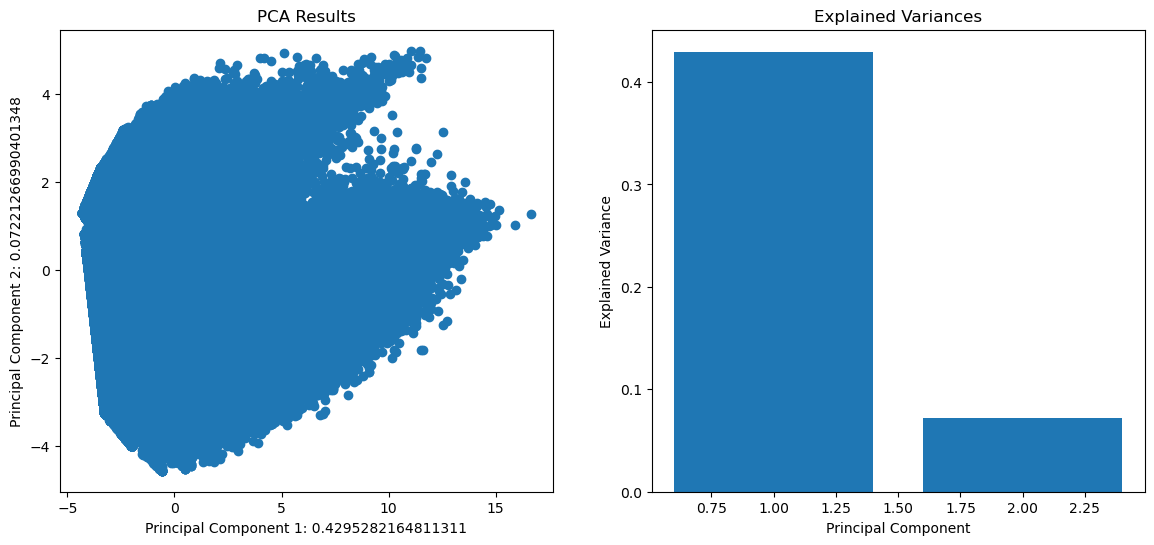

In [42]:
X_pca = pca.fit_transform(style_pref_merged)


explained_variances = pca.explained_variance_ratio_

# Create a new DataFrame with the PCA results
df_pca = pd.DataFrame(data=X_pca, columns=[f'Principal_Component_{i+1}' for i in range(X_pca.shape[1])])

# Plot the results with variances
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot of the first two principal components
ax1.scatter(df_pca['Principal_Component_1'], df_pca['Principal_Component_2'])
ax1.set_title('PCA Results')
ax1.set_xlabel(f'Principal Component 1: {explained_variances[0]}')
ax1.set_ylabel(f'Principal Component 2: {explained_variances[1]}')

# Bar plot of explained variances
ax2.bar(range(1, len(explained_variances) + 1), explained_variances)
ax2.set_title('Explained Variances')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Explained Variance')

plt.show()

/Users/sebastofi/opt/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


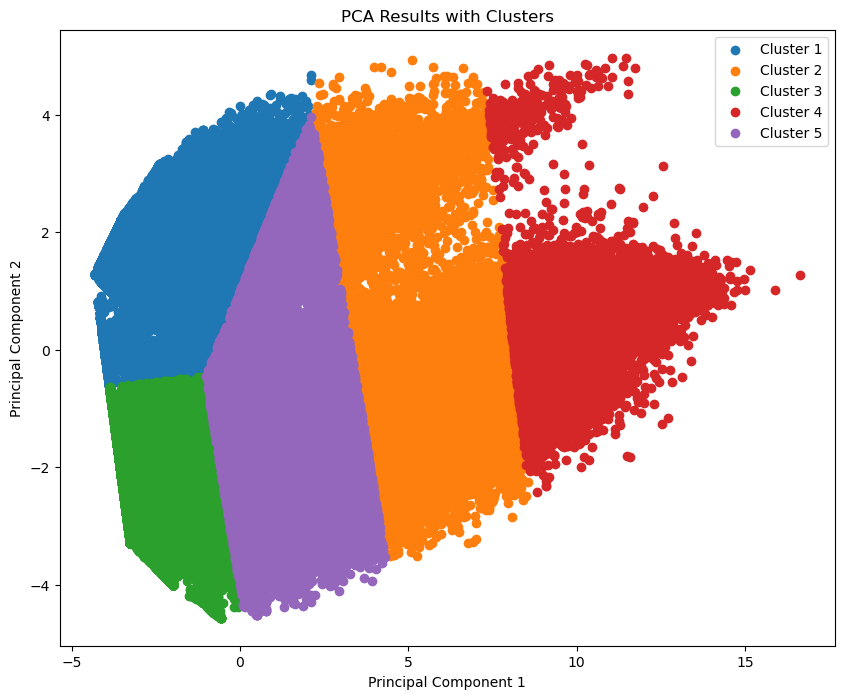

In [45]:
from sklearn.cluster import KMeans

# Perform k-means clustering on the PCA-transformed data
num_clusters = 5  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_pca['Cluster'] = kmeans.fit_predict(X_pca)

# Plot the results with color-coded clusters
plt.figure(figsize=(10, 8))

for cluster in range(num_clusters):
    plt.scatter(df_pca[df_pca['Cluster'] == cluster]['Principal_Component_1'],
                df_pca[df_pca['Cluster'] == cluster]['Principal_Component_2'],
                label=f'Cluster {cluster + 1}')

plt.title('PCA Results with Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [35]:
df_pca = pd.DataFrame(np.transpose(pca.components_))
df_pca

,0,1
0,0.238354,0.082394
1,0.237105,0.020936
2,0.212922,0.115696
3,0.269752,0.047815
4,0.047210,0.034144
5,0.206154,0.163792
6,0.228782,0.088238
7,0.221494,0.064342
8,0.213072,-0.910705
9,0.024703,0.016627
